# Tutorial 4 - Artificial Neural Networks

## Overview

Welcome to the Python Tutorial on Artificial Neural Networks (ANNs)! In this comprehensive guide, we will delve into one of the most powerful and versatile tools in machine learning, inspired by the structure and functioning of the human brain.

Artificial Neural Networks are a class of deep learning algorithms that excel at learning complex patterns and representations from data. ANNs have found applications in various domains, such as image and speech recognition, natural language processing, and recommendation systems.

In this tutorial, we will cover the fundamentals of Artificial Neural Networks, their architecture, and the mathematics behind their working. We will also explore different types of ANN architectures, such as feedforward networks and recurrent networks, and discuss their use cases.

## Prerequisites

Before diving into this tutorial, it is recommended to have a solid understanding of the following topics:

- Python programming fundamentals
- Basic concepts of machine learning, including supervised and unsupervised learning
- Linear algebra concepts, such as matrices and vectors
- Calculus, particularly derivatives

Knowledge of libraries like NumPy, scikit-learn and Pytorch will be beneficial.

## What You'll Learn

By the end of this tutorial, you will:

- Understand the structure and components of Artificial Neural Networks.
- Be familiar with different activation functions and how they affect the network's behavior.
- Learn about the forward and backward propagation algorithms used in training ANNs.
- Implement basic feedforward networks in Python.
- Explore advanced engineering topics, such as regularization techniques and optimization algorithms.
- Apply ANNs to real-world datasets and solve classification and regression problems.

## Problem Description

Consider the ridership of a public transportation system in the San Francisco
bay area, Bay Area Rapid Transit (BART). Recently, a group of researchers is
assuming that the ridership of the transit system is related to some
socio-economic factors, which are preliminarily the **total population near
each station, number of households that own 0 vehicles, total
employment, and total road network density**. The raw census data is
collected by the [Environment Protection Agency of the United States](https://www.epa.gov/sites/default/files/2021-06/documents/epa_sld_3.0_technicaldocumentationuserguide_may2021.pdf) while
the ridership data is available at the BART’s [official website](https://www.bart.gov/about/reports/ridership). The data for the
catchment area for each station is processed by Github user [HaTT2018](https://github.com/HaTT2018/BART_Ridership_Prediction).

To make this problem as simple as possible, we only investigate the ridership from station *Embarcadero* (the CBD of San Francisco) to other stations. (picture adopted from https://www.bart.gov/system-map)

<img title="Map of BART" src="./img/BART.png" width="800">

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale

In [3]:
# take the first 48 stations becasue the 
# last 2 stations were not yet opened
# by the time this data was collected
data_BART_sld = pd.read_csv('data_X.csv').iloc[:48, 1:]
data_BART_sld.head()

,TotPop,AutoOwn0,TotEmp,Tot Rd Dens
0,11084,1664,33120,42.232657
1,142973,20505,103479,32.296762
2,36177,4704,47570,31.822631
3,104191,8018,39663,32.894203
4,70630,1142,13924,20.531431


In [4]:
# The file "3d_daily.npy" contains the daily ridership
# data from each station to all the other stations.
# Its shape is [50, 50, 365]. Each dimension represents
# origin, destination, day in the year respectively

# Embarcadero is the 18th station in the list
OD_BART = np.load('3d_daily.npy').sum(axis=2)[17, :48]

In [5]:
print('Shape of data_BART_sld', data_BART_sld.shape)
print('Shape of OD_BART', OD_BART.shape)

Shape of data_BART_sld (48, 4)
Shape of OD_BART (48,)


## The model layout

Our job is to train an MLP model which takes "data_BART_sld" as input and generate "OD_BART" as output and make it as close to the real data as possible.

Consider a simple MLP, with 1 input layer, 1 hidden layer, and 1 output layer. The input layer has a dimension of 4 because we have 4 attributes of the scio-economic census. The output layer is 1-dimensional because the ridership is a scalar. The number of dimension of the hidden layer is set to be 2 for the sake of simplicity. The activation function is Sigmoid function as introduced in the lecture.

<img src="./img/MLP_demo.png" width="500">

## Using PyTorch

In [1]:
%pip install torch
%pip install torchvision
%pip install torchinfo

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import TensorDataset
from torchvision import datasets

### Define a network
The structure used here is called "class", you can consider it as an object, here it is a network.

In [7]:
# Model specification
class Simple_Network(nn.Module):
    def __init__(self, inp_dim, hid_dim, out_dim):
        super(Simple_Network, self).__init__()
        
        self.input_layer = nn.Sequential(
            nn.Linear(inp_dim, hid_dim),
            nn.Sigmoid(),
        )
        
        self.output_layer = nn.Sequential(
            nn.Linear(hid_dim, out_dim)
        )
        
    def forward(self, x):
        # x is the input data
        

        h = self.input_layer(x)  # h represents for the output for hidden layer
        y = self.output_layer(h)
        return y

### Prepare data
We divide the original data into two parts, 70% for training and 30% for model validation. Thus, the first 33 samples are for training, and the rest of the samples are for validation.

In [8]:
# I'm copying the data definition here
X_train = minmax_scale(data_BART_sld)[:33, :]
y_train = minmax_scale(OD_BART)[:33].reshape(-1, 1)
X_val = minmax_scale(data_BART_sld)[33:, :]
y_val = minmax_scale(OD_BART)[33:].reshape(-1, 1)

In [9]:
# this line returns the device that you are going to use
# if cuda is successfully installed, it will return "cuda"
# otherwise, "cpu"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)

# minibatch training, useful for big data, not useful here but I'm showing how to do this
# to realize full batch training, simply set this value to be very large
batch_size = 100  
loader_train = torch.utils.data.DataLoader(
    TensorDataset(X_train, y_train), batch_size, shuffle=True
)
iter_train = iter(loader_train)

### Train

In [10]:
# define the model and loss function
## you can play with different model specifications here!
## think about what part of the model you are modifying.
inp_dim = 4
hid_dim = 2
out_dim = 1

model = Simple_Network(inp_dim, hid_dim, out_dim).to(device)
loss_func = nn.MSELoss()

train_loss_torch = []
val_loss_torch = []

optimizer = optim.SGD(model.parameters(), lr=0.01)  # lr refers to learning rate

In [11]:
# the model specification
summary(model)

Layer (type:depth-idx)                   Param #
Simple_Network                           --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       10
│    └─Sigmoid: 2-2                      --
├─Sequential: 1-2                        --
│    └─Linear: 2-3                       3
Total params: 13
Trainable params: 13
Non-trainable params: 0

In [12]:
model.train()
epochs = 200

for e in range(epochs):
    for i in range(len(loader_train)):
        # obtian X and y from the dataloader
        try:
            X, y = next(iter_train)
        except:
            iter_train = iter(loader_train)
            X, y = next(iter_train)
        
        out = model(X)  # forward propagation
        loss = loss_func(out, y)  # training loss

        out_val = model(X_val)
        loss_val = loss_func(out_val, y_val)  # validation loss

        optimizer.zero_grad()
        loss.backward()  # backward propagation
        optimizer.step()  # update

        val_loss_torch.append(loss_val.cpu().detach().numpy())
        train_loss_torch.append(loss.cpu().detach().numpy())
    if e%50==0:
        print('Epoch %i   success, val loss:%.6f, train loss:%.6f'%(
            e, loss_val.cpu().detach().numpy(), loss.cpu().detach().numpy()
        ))
        

Epoch 0   success, val loss:0.416174, train loss:0.513156
Epoch 50   success, val loss:0.045714, train loss:0.071109
Epoch 100   success, val loss:0.042941, train loss:0.054289
Epoch 150   success, val loss:0.045007, train loss:0.053657


### Visualize the loss

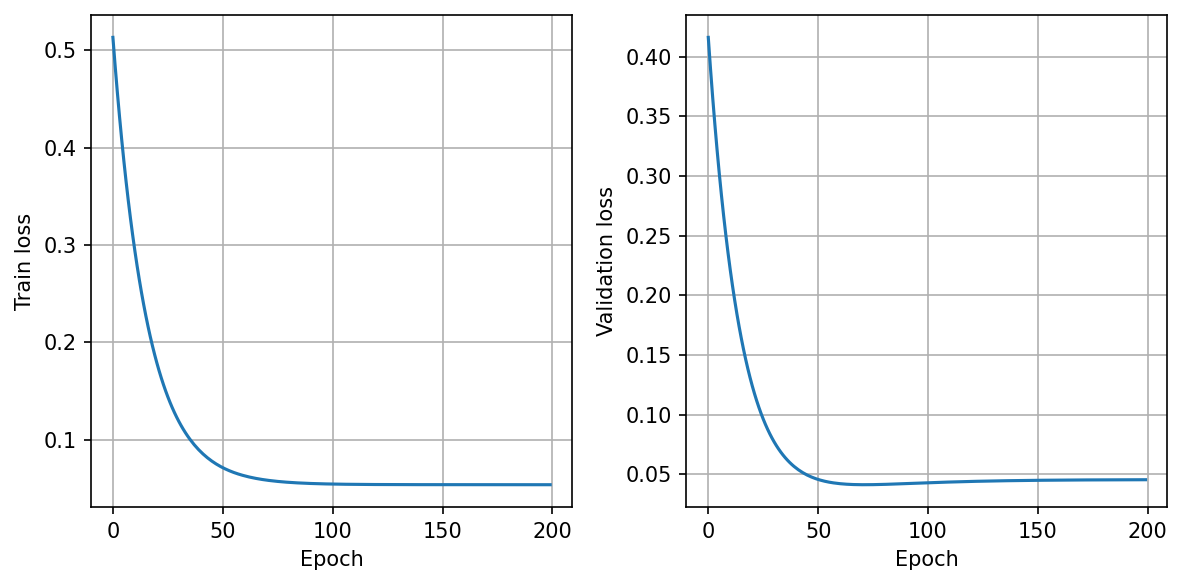

In [13]:
fig = plt.figure(figsize=[8, 4], dpi=150)
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(train_loss_torch)
ax1.grid()
ax1.set_ylabel('Train loss')
ax1.set_xlabel('Epoch')

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(val_loss_torch)
ax2.grid()
ax2.set_ylabel('Validation loss')
ax2.set_xlabel('Epoch')

plt.tight_layout()

### Visualize the result

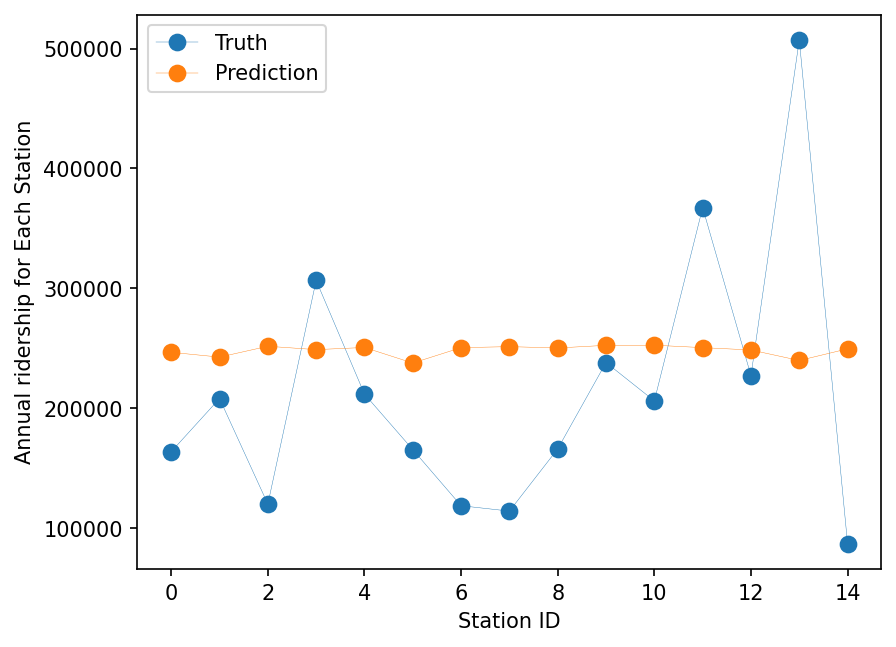

In [14]:
y_pred_torch = model(X_val).cpu().detach().numpy().flatten()
y_val_torch = y_val.cpu().detach().numpy().flatten()

plt.figure(dpi=150)
plt.plot(y_val_torch*(OD_BART.max() - OD_BART.min()) + OD_BART.min(), '.-', linewidth=0.2, markersize=15, label='Truth')
plt.plot(y_pred_torch*(OD_BART.max() - OD_BART.min()) + OD_BART.min(), '.-', linewidth=0.2, markersize=15, label='Prediction')
plt.xlabel("Station ID")
plt.ylabel("Annual ridership for Each Station")
plt.legend()

## Using matrix representation (Optional)

Our job is to train an MLP model which takes "data_BART_sld" as input and generate "OD_BART" as output and make it as close to the real data as possible.

Consider a simple MLP, with 1 input layer, 1 hidden layer, and 1 output layer. The input layer has a dimension of 4 because we have 4 attributes of the scio-economic census. The output layer is 1-dimensional because the ridership is a scalar. The number of dimension of the hidden layer is set to be 2 for the sake of simplicity. The activation function is Sigmoid function as introduced in the lecture.

<img src="./img/MLP_demo.png" width="500">

We do not consider bias in this network for sake of simplicity. 

$o1 = k_1 \times a_1 + k_2 \times a_2$

$a_1 = \sigma(h_1)$,
$a_2 = \sigma(h_2)$ 

$h_1 = x_1 \times w_{11}+x_2 \times w_{12}+x_3 \times w_{13}+x_4 \times w_{14}$ 

$h_2 = x_2 \times w_{21}+x_2 \times w_{22}+x_3 \times w_{23}+x_4 \times w_{24}$ 

In vector-matrix form, we have:

$\mathbf{x} = \begin{bmatrix} x_1 \\ x_2 \\ x_3 \\ x_4 \end{bmatrix}$,
$\mathbf{h} = \begin{bmatrix} h_1 \\ h_2 \end{bmatrix}$,
$\mathbf{a} = \begin{bmatrix} a_1 \\ a_2 \end{bmatrix}$,
$\mathbf{W} = \begin{bmatrix} w_{11} & w_{12} & w_{13} & w_{14} \\ w_{21} & w_{22} & w_{23} & w_{24} \end{bmatrix}$,
$\mathbf{K} = \begin{bmatrix} k_1 & k_2 \end{bmatrix}$ 

$\mathbf{h} = \mathbf{W} \times \mathbf{x}$

$\mathbf{a} = \sigma(\mathbf{h})$

$\mathbf{o} = \mathbf{K} \times \mathbf{a}$

Finally, $\mathbf{o} = \mathbf{K} \times \sigma(\mathbf{W} \times \mathbf{x})$

### Gradient descent and the loss function

Suppose the label true value is $y$ given input $\mathbf{x} = \begin{bmatrix} x_1 \\ x_2 \\ x_3 \\ x_4 \end{bmatrix}$, and we use squared loss function $L = \frac{1}{2}(o1 - y)^2$, which represents how much the output is deviated from the true value.

$\mathbf{W}$ and $\mathbf{K}$ contain all the parameters (10 numbers in total) we need to update in the training process.

Before training starts, we assign some random initial values to our parameters $\mathbf{W}$ and $\mathbf{K}$.

During training, we obtain $\frac{\partial L}{\partial \mathbf{W}}$ and $\frac{\partial L}{\partial \mathbf{K}}$, then we use $\mathbf{W}_i = \mathbf{W}_{i-1} - \frac{\partial L}{\partial \mathbf{W}} \times lr$ and $\mathbf{K}_i = \mathbf{K}_{i-1} - \frac{\partial L}{\partial \mathbf{K}} \times lr$ to update $\mathbf{W}$ and $\mathbf{K}$ in order to make loss $L$ smaller and smaller.

This is the basic idea of gradient decent, which is a popular set of non-convex optimization methods used in machine learning especially in deep learning.

### The expressions for the gradients of our 8 parameters in $W$ and 2 parameters in $K$

Our loss function is: $L = \frac{1}{2}(o_{1}-y)^2 = \frac{1}{2}(\mathbf{K} \times \mathbf{a} - y)^2 = \frac{1}{2}((k_1 \times a_1 + k_2 \times a_2) - y)^2$

$\frac{\partial L}{\partial \mathbf{K}} = 
\begin{bmatrix} \frac{\partial L}{\partial k_1} & \frac{\partial L}{\partial k_2} \end{bmatrix} = 
\begin{bmatrix} \frac{\partial L}{\partial o_{1}} \frac{\partial o_{1}}{\partial k_1} & \frac{\partial L}{\partial o_{1}} \frac{\partial o_{1}}{\partial k_2} \end{bmatrix} = 
\begin{bmatrix} (o_{1}-y) a_1 & (o_{1}-y) a_2 \end{bmatrix} = 
\left(\begin{bmatrix}a_1 \\ a_2\end{bmatrix}(o_{1}-y)\right)^T = (o_{1}-y)^T\mathbf{a}^T$

$\frac{\partial L}{\partial \mathbf{W}}$ = 
$\begin{bmatrix} 
\frac{\partial L}{\partial w_{11}} & \frac{\partial L}{\partial w_{12}} & \frac{\partial L}{\partial w_{13}} & \frac{\partial L}{\partial w_{14}} \\ 
\frac{\partial L}{\partial w_{21}} & \frac{\partial L}{\partial w_{22}} & \frac{\partial L}{\partial w_{23}} & \frac{\partial L}{\partial w_{24}}
\end{bmatrix}$ = 
$\begin{bmatrix} 
  \frac{\partial L}{\partial o_{1}}\frac{\partial o_{1}}{\partial a_1}\frac{\partial a_1}{\partial h_1}\frac{\partial h_1}{\partial w_{11}} 
& \frac{\partial L}{\partial o_{1}}\frac{\partial o_{1}}{\partial a_1}\frac{\partial a_1}{\partial h_1}\frac{\partial h_1}{\partial w_{12}} 
& \frac{\partial L}{\partial o_{1}}\frac{\partial o_{1}}{\partial a_1}\frac{\partial a_1}{\partial h_1}\frac{\partial h_1}{\partial w_{13}}
& \frac{\partial L}{\partial o_{1}}\frac{\partial o_{1}}{\partial a_1}\frac{\partial a_1}{\partial h_1}\frac{\partial h_1}{\partial w_{14}} \\ 
  \frac{\partial L}{\partial o_{1}}\frac{\partial o_{1}}{\partial a_2}\frac{\partial a_2}{\partial h_2}\frac{\partial h_2}{\partial w_{21}} 
& \frac{\partial L}{\partial o_{1}}\frac{\partial o_{1}}{\partial a_2}\frac{\partial a_2}{\partial h_2}\frac{\partial h_2}{\partial w_{22}} 
& \frac{\partial L}{\partial o_{1}}\frac{\partial o_{1}}{\partial a_2}\frac{\partial a_2}{\partial h_2}\frac{\partial h_2}{\partial w_{23}} 
& \frac{\partial L}{\partial o_{1}}\frac{\partial o_{1}}{\partial a_2}\frac{\partial a_2}{\partial h_2}\frac{\partial h_2}{\partial w_{24}} 
\end{bmatrix}$ =
$\begin{bmatrix} 
  (o_{1}-y)k_1\frac{\partial \sigma(h_1)}{\partial h_1}x_1 
& (o_{1}-y)k_1\frac{\partial \sigma(h_1)}{\partial h_1}x_2
& (o_{1}-y)k_1\frac{\partial \sigma(h_1)}{\partial h_1}x_3
& (o_{1}-y)k_1\frac{\partial \sigma(h_1)}{\partial h_1}x_4 \\ 
  (o_{1}-y)k_2\frac{\partial \sigma(h_2)}{\partial h_2}x_1
& (o_{1}-y)k_2\frac{\partial \sigma(h_2)}{\partial h_2}x_2
& (o_{1}-y)k_2\frac{\partial \sigma(h_2)}{\partial h_2}x_3
& (o_{1}-y)k_2\frac{\partial \sigma(h_2)}{\partial h_2}x_4
\end{bmatrix}$ = 
$(o_{1}-y)\begin{bmatrix} 
k_1\frac{\partial \sigma(h_1)}{\partial h_1} \\ 
k_2\frac{\partial \sigma(h_2)}{\partial h_2}
\end{bmatrix} \begin{bmatrix} x_1 & x_2 & x_3 & x_4 \end{bmatrix}$ =
$\begin{bmatrix}
k_1 & 0 \\
0 & k_2 
\end{bmatrix}
\begin{bmatrix} 
\frac{\partial \sigma(h_1)}{\partial h_1} \\ 
\frac{\partial \sigma(h_2)}{\partial h_2}
\end{bmatrix} 
(o_{1}-y)
\begin{bmatrix} x_1 & x_2 & x_3 & x_4 \end{bmatrix}$

In [15]:
# define the sigmoid function
def sigmoid(X):
    # X: A numpy.ndarray object
    
    return 1 / (1 + np.exp(-X))

In [16]:
# define the partial derivative of sigmoid function
def psigmoid(X):
    # X: A numpy.ndarray object

    return np.exp(-X) / (1 + np.exp(-X))**2

In [17]:
# define the forward propagation
def DNNforward(X, W, K):
    # X: dataset input features, numpy.ndarray of shape (n, 4)
    # W: current weight matrix W, numpy.ndarray of shape (2, 4)
    # K: current weight matrix K, numpy.ndarray of shape (2,)
    # return: (H, A, O)
    # H: current hidden layer output value H, numpy.ndarray of shape (2, n)
    # A: current activation layer output A, numpy.ndarray of shape (2, n)
    # O: current DNN model output O, numpy.ndarray of shape (n, )
    
    H = W @ X.T
    A = sigmoid(H)
    O = K @ A
    
    return H, A, O

In [18]:
# define the backward propagation
def DNNbackward(X, y, W, K, H, A, O):
    # X: dataset input features, numpy.ndarray
    # y: dataset labels, numpy.ndarray
    # W: current weight matrix W, numpy.ndarray
    # K: current weight matrix K, numpy.ndarray
    # H: current hidden layer output value H, numpy.ndarray
    # A: current activation layer output A, numpy.ndarray
    # O: current DNN model output O, numpy.ndarray
    # return: (pLpW, pLpK)
    # pLpW: current gradient of Loss with respect to W
    # pLpK: current gradient of Loss with respect to K
    
    pLpW = np.array([[K[0], 0], [0, K[1]]]) @ psigmoid(H) * (O-y) @ X
    pLpK = (O-y).T @ A.T
    
    # we are considering the mean derivative of all data samples!
    return pLpW/X.shape[0], pLpK/X.shape[0]

In [19]:
# gradient decent function in batches
def train(X, y, W, K, lr, num_epochs=10, batch_size=10, print_loss=False):
    # X: dataset input features, numpy.ndarray
    # y: dataset labels, numpy.ndarray
    # W: current weight matrix W, numpy.ndarray
    # K: current weight matrix K, numpy.ndarray
    # lr: learning rate, float or int
    # nump_epochs: total number of epochs we train our NN model, int
    # batch_size: number of samples in each batch, int
    # print_loss: whether we print loss in each epoch during training, bool
    # return: (W_list, K_list)
    # W_list: list of numpy.ndarrays containing all the W parameters after each epoch
    # K_list: list of numpy.ndarrays containing all the K parameters after each epoch
    W_list, K_list = [], []
    train_loss, val_loss = [], []
    dataset_size = len(y)
    for epoch in range(num_epochs):
        for batch_idx in range(int(np.ceil(dataset_size/batch_size))):
            start_idx = batch_idx * batch_size
            end_idx = min((batch_idx+1)*batch_size, dataset_size-1)
            H, A, O = DNNforward(X[start_idx:end_idx], W, K)
            if print_loss and epoch%50==0:
                print("Epoch "+str(epoch+1)+", batch "+str(batch_idx+1)+", loss = "+str(loss(y[start_idx:end_idx], O)), end='\n')
            # update W and K
            pLpW, pLpK = DNNbackward(X[start_idx:end_idx, :], y[start_idx:end_idx], W, K, H, A, O)
            W = W - lr*pLpW
            K = K - lr*pLpK
            train_loss.append(loss(y[start_idx:end_idx], O))
            
            _,_,y_val_pred = DNNforward(X_val, W, K)
            val_loss.append(loss(y_val_pred, y_val))
            
        W_list.append(W)
        K_list.append(K)
    return W_list, K_list, train_loss, val_loss

In [20]:
# define the loss function
def loss(y, O):
    # we use squared loss
    return np.mean(1/2 * (y-O)**2)

### Prepare data
We divide the original data into two parts, 70% for training and 30% for model validation. Thus, the first 33 samples are for training, and the rest of the samples are for validation.

In [21]:
X_train = minmax_scale(data_BART_sld)[:33, :]
y_train = minmax_scale(OD_BART)[:33]
X_val = minmax_scale(data_BART_sld)[33:, :]
y_val = minmax_scale(OD_BART)[33:]

In [22]:
# initialize weight parameters
np.random.seed(10)
W = np.random.uniform(size=(2,4))
K = np.random.uniform(size=(2))

# set learning rate
lr = 0.01

In [23]:
# we use full-batch train
W_list, K_list, train_loss, val_loss  = train(X_train, y_train, W, K, lr, num_epochs=300, batch_size=50, print_loss=True)


Epoch 1, batch 1, loss = 0.05688507939769296
Epoch 51, batch 1, loss = 0.03854631470613812
Epoch 101, batch 1, loss = 0.03130794539324819
Epoch 151, batch 1, loss = 0.028456412059598674
Epoch 201, batch 1, loss = 0.027334567502242717
Epoch 251, batch 1, loss = 0.026893377356756187


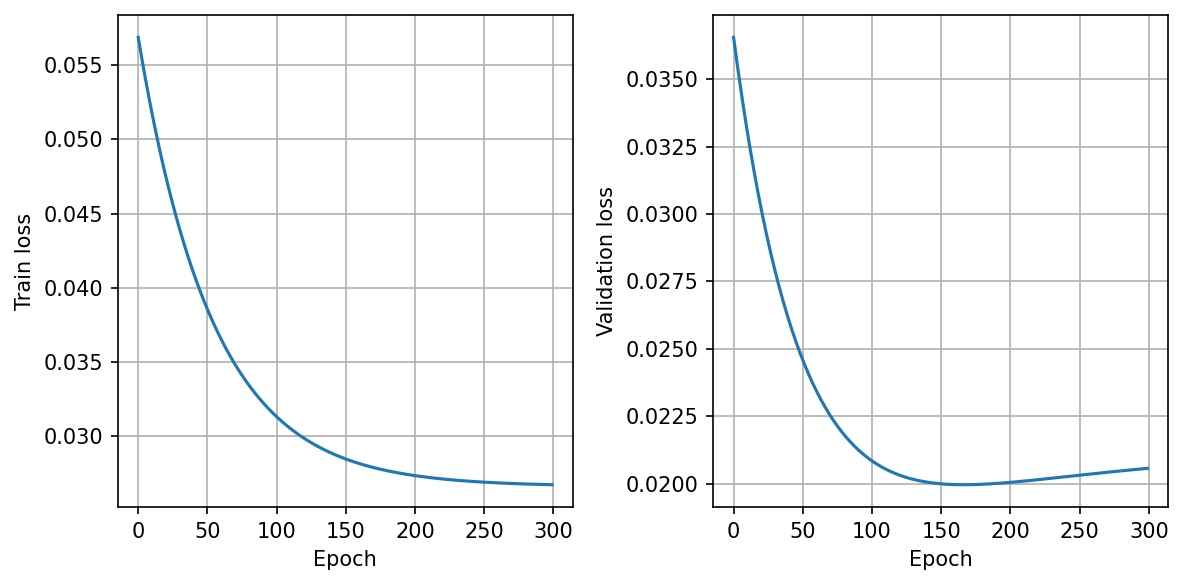

In [24]:
fig = plt.figure(figsize=[8, 4], dpi=150)
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(train_loss)
ax1.grid()
ax1.set_ylabel('Train loss')
ax1.set_xlabel('Epoch')

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(val_loss)
ax2.grid()
ax2.set_ylabel('Validation loss')
ax2.set_xlabel('Epoch')

plt.tight_layout()

In [25]:
# make prediction
_, _, y_pred = DNNforward(X_val, W_list[-1], K_list[-1])
y_pred

array([0.38161384, 0.43811272, 0.41512816, 0.38338839, 0.40811861,
       0.40577422, 0.31843194, 0.38865472, 0.40166894, 0.4184795 ,
       0.37220886, 0.35665281, 0.3740504 , 0.38458152, 0.33036378])

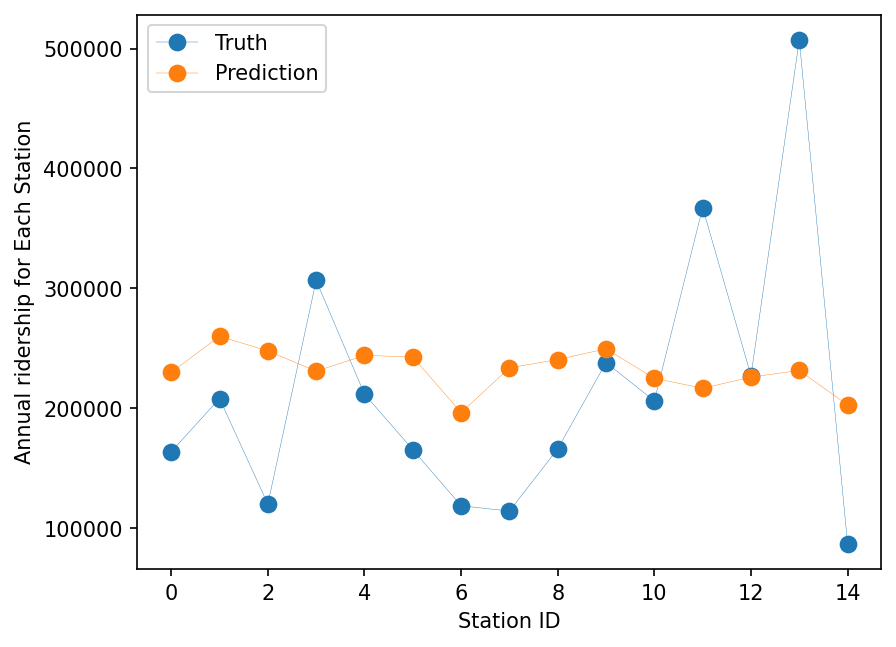

In [26]:
plt.figure(dpi=150)
plt.plot(y_val*(OD_BART.max() - OD_BART.min()) + OD_BART.min(), '.-', linewidth=0.2, markersize=15, label='Truth')
plt.plot(y_pred*(OD_BART.max() - OD_BART.min()) + OD_BART.min(), '.-', linewidth=0.2, markersize=15, label='Prediction')
plt.xlabel("Station ID")
plt.ylabel("Annual ridership for Each Station")
plt.legend()